In [79]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt
import seaborn as sns
from tqdm import tqdm
from itertools import combinations

from filtering import freq_filt

banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
res.loc[:, 'analyze'] = 0
for i, r in res[res.selected == 1].iterrows():
    dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
    day = days[dt]
    if day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
        res.loc[i, 'analyze'] = 1
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/psd_results'
data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [225]:
def corr_heights(df, win_len = 100):
    hs = [0.33,0.66,1,1.33,2]
    cols = [f'{i[0]}-{i[1]}' for i in set(combinations(hs, 2))]
    res = np.zeros((int(len(df)/win_len)+1, len(cols)))
    lags = np.zeros((int(len(df)/win_len)+1, len(cols)))
    for j, (h1,h2) in enumerate(combinations(hs, 2)):
        i = we = 0
        k= 0
        while we < len(df) or i == 0:
            ws = i
            we = i + win_len
            # corrs = df.iloc[ws:we].corr()
            sub = df.iloc[ws:we]
            c = np.correlate(sub[h1].values, sub[h2].values, 'full')

            # res[k, j] = corrs.loc[h1, h2]
            res[k, j] = np.max(c)
            lags[k, j] = np.argmax(c) - (np.floor(c.size/2)+1)
            k += 1
            i += win_len
    return pd.DataFrame(res, columns = cols), pd.DataFrame(lags, columns = cols)

-2.0
0.08172490956407305


(5995.0, 6005.0)

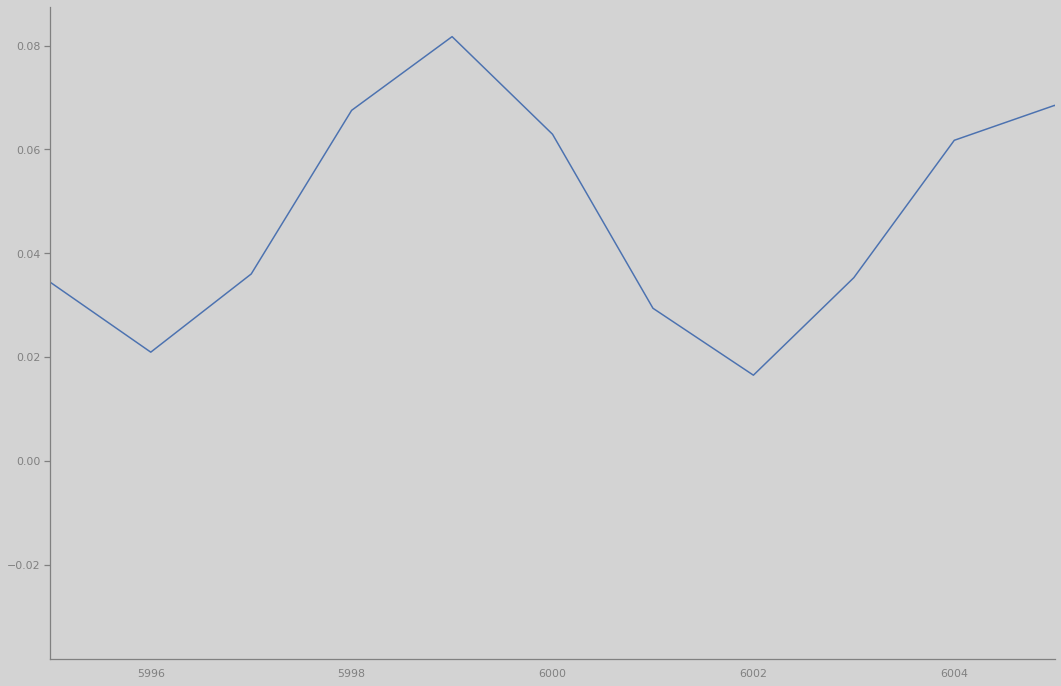

In [201]:
c = np.correlate(df[0.33].values, df[1.33].values, 'full')
print(np.argmax(c) - (np.floor(c.size/2)+1))
print(np.max(c))
plt.plot(c)
plt.xlim(5995,6005)

In [310]:
sns.set(rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'font.family':'Arial',
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

In [311]:
ss = []
ps = []
corrs = []
lags = []
dfs = []
for i, r in tqdm(res[res.analyze == 1].iterrows(), total = len(res[res.analyze == 1])):
    dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
    day = days[dt]
    sig = {}
    psig = {}
    s = pd.to_datetime(r.time) + pd.Timedelta('0 second')
    e = s + pd.Timedelta('30 second')
    pres = s - pd.Timedelta('30 seconds')

    try:
        if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
            for name, fp in day.items():
                if name != 'snotel':
                    par = pd.read_parquet(fp)
                    sig[name] = freq_filt(par[s:e].values.ravel(), 1, kind = 'highpass')
                    psig[name] = freq_filt(par[pres:s].values.ravel(), 1, kind = 'highpass')
            df = pd.DataFrame(sig)
            dfs.append(df)
            # pre_df = pd.DataFrame(psig)
            ave_pow = np.cumsum(df.drop([2], axis = 1).mean(axis = 1)**2)
            # pre_pow = np.cumsum(pre_df.mean(axis = 1)**2)
            ss.append(ave_pow)
            # ps.append(pre_pow)
            co, lag = corr_heights(df, win_len=50)
            corrs.append(co)
            lags.append(lag)
    except ValueError as e:
        print(dt)
        print(e)

  3%|▎         | 2/66 [00:12<06:27,  6.06s/it]

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


100%|██████████| 66/66 [05:20<00:00,  4.85s/it]


In [332]:
from matplotlib import colors

print(colors.to_rgba('grey'))

(0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 1.0)


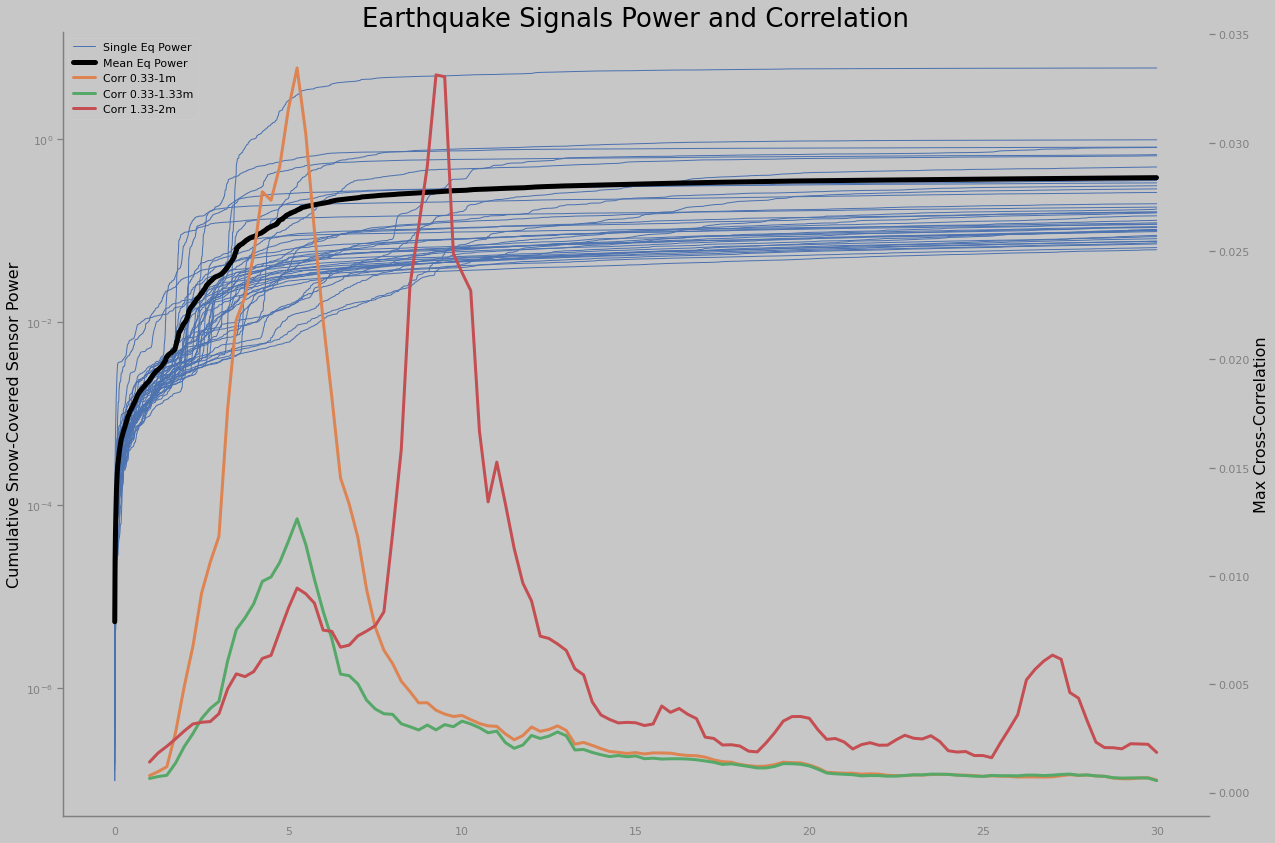

In [339]:
colorn = 0.78
f, ax = plt.subplots(facecolor = (colorn,colorn,colorn, 1.0))
ax2 = ax.twinx()
r = ss[0]
for i, s in enumerate(ss):
    if i != 0:
        r = r + s
        sns.lineplot(x = np.linspace(0, 30, len(s)), y = s, ax = ax, linewidth = 1, color = 'C0')
    else:
        sns.lineplot(x = np.linspace(0, 30, len(s)), y = s, ax = ax, linewidth = 1, label = 'Single Eq Power', color = 'C0')
r = r/len(ss)
sns.lineplot(x = np.linspace(0, 30, len(r)), y = r, ax = ax, color = 'Black', linewidth = 5, label = 'Mean Eq Power')

# Corr
# r033_1 = 0
# r033_066 = 0
# r133_2 = 0
hs = [0.33,0.66,1,1.33,2]
cols = [f'{i[0]}-{i[1]}' for i in set(combinations(hs, 2))]
d = {}
k = 1
for col in cols:
    if '0.33-1' in col or '1.33-2' in col:
        for i, co in enumerate(corrs):
            if i == 0:
                d[col] = co[col].rolling(5).mean()
            else:
                d[col] += co[col].rolling(5).mean()

        d[col] = d[col]/len(corrs)

        sns.lineplot(x = np.linspace(0, 30, len(co)), y = d[col], linewidth = 3, ax = ax2, label = f'Corr {col}m', color = f'C{k}')
        k += 1
# i = 15
# sns.lineplot(x = np.linspace(0, 30, len(ss[i])), y = ss[i], color = 'purple', linewidth = 10, label = 'Single Eq Power', ax = ax)
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax2.get_legend().remove()
# plt.legend()
ax.set_yscale('log')
# ax2.set_ylim(-.2,1)
# ax2.set_yscale('log')

plt.title('Earthquake Signals Power and Correlation')
plt.xlabel('Seconds since Earthquake')
ax2.set_ylabel('Max Cross-Correlation')
ax.set_ylabel('Cumulative Snow-Covered Sensor Power')
plt.tight_layout()
plt.savefig(join('/bsuhome/zacharykeskinen/infrasound/figures/psd_window', 'corr_energy.png'), dpi = 300)

In [289]:
len(corrs)

40

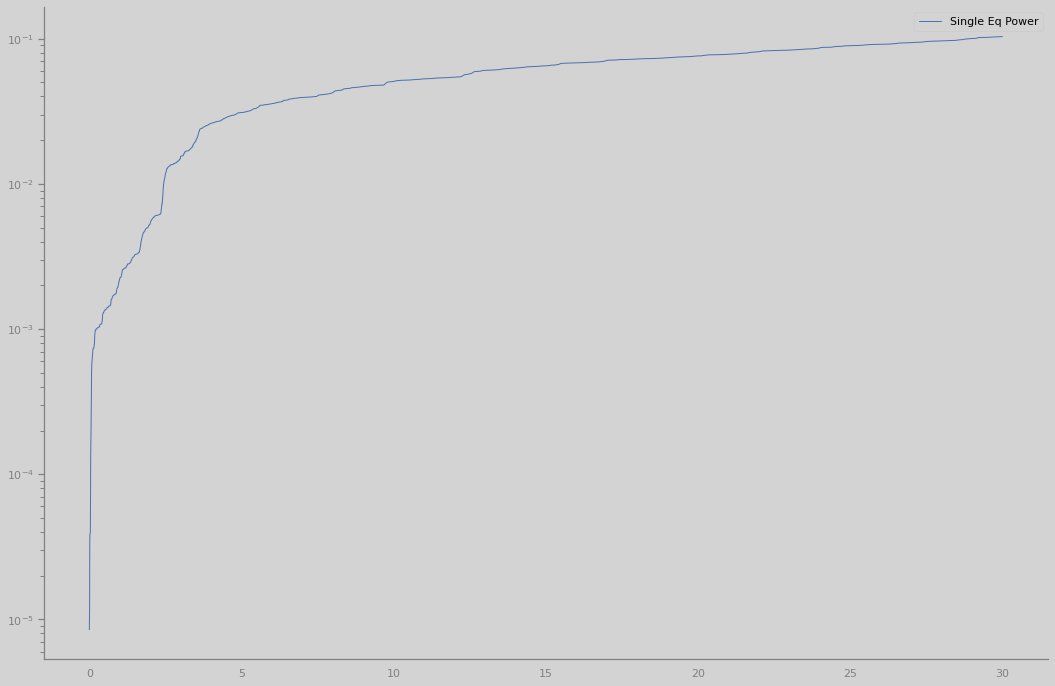

<AxesSubplot:>

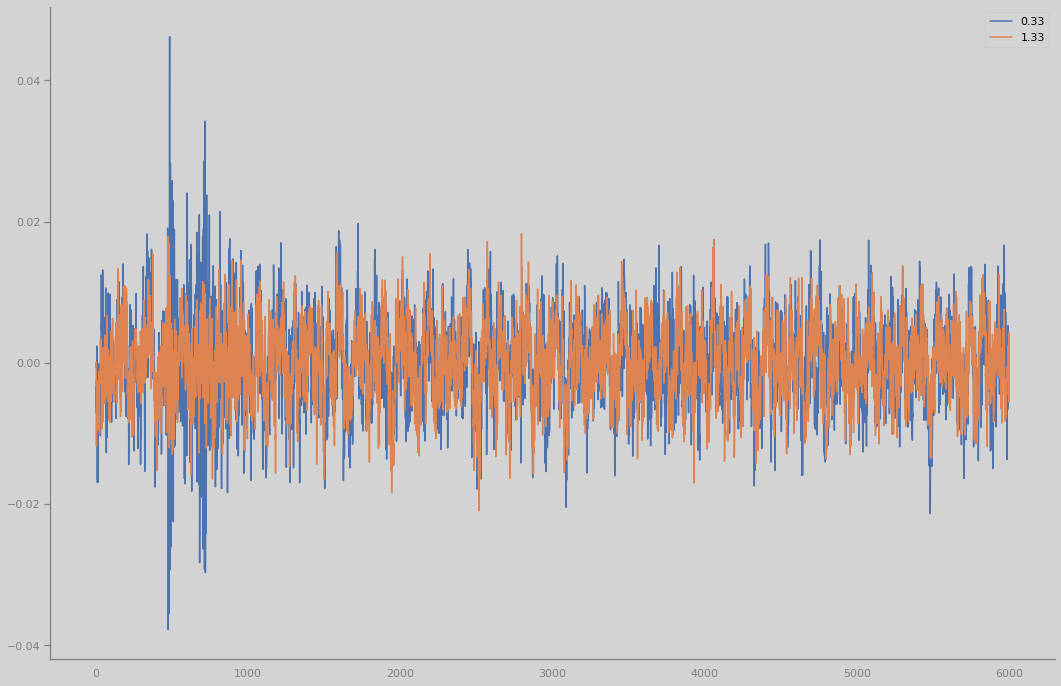

In [285]:
i = 20
sns.lineplot(x = np.linspace(0, 30, len(ss[i])), y = ss[i], color = 'C0', linewidth = 1, label = 'Single Eq Power')
plt.yscale('log')
plt.show()
dfs[i][[0.33,1.33]].plot()

<AxesSubplot:>

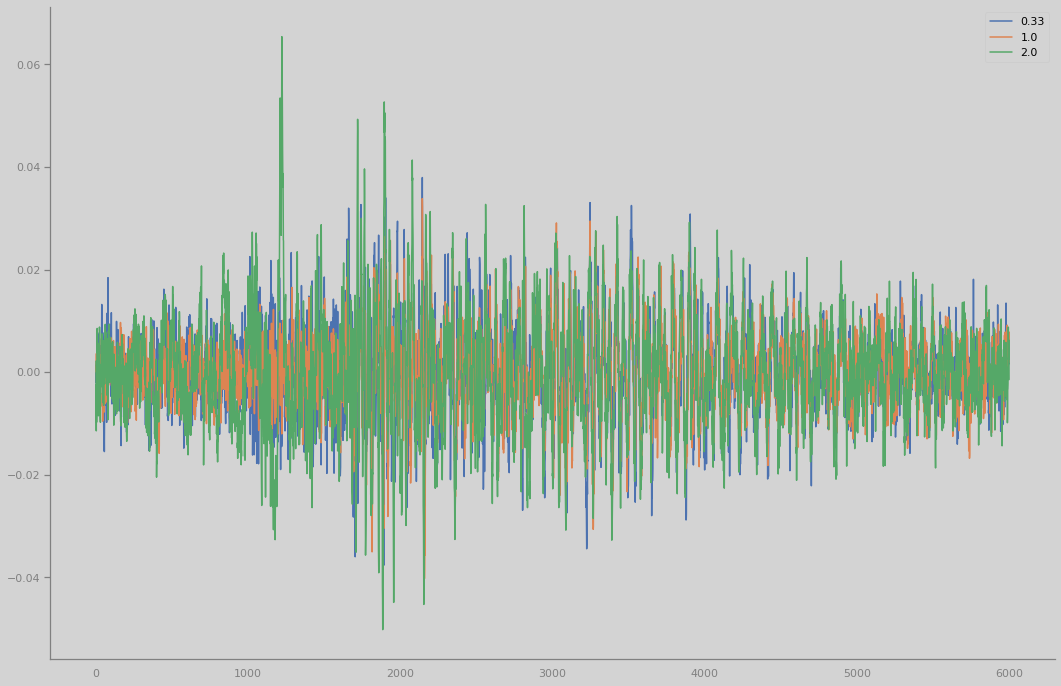

In [258]:
dfs[i][[0.33,1,2]].plot()

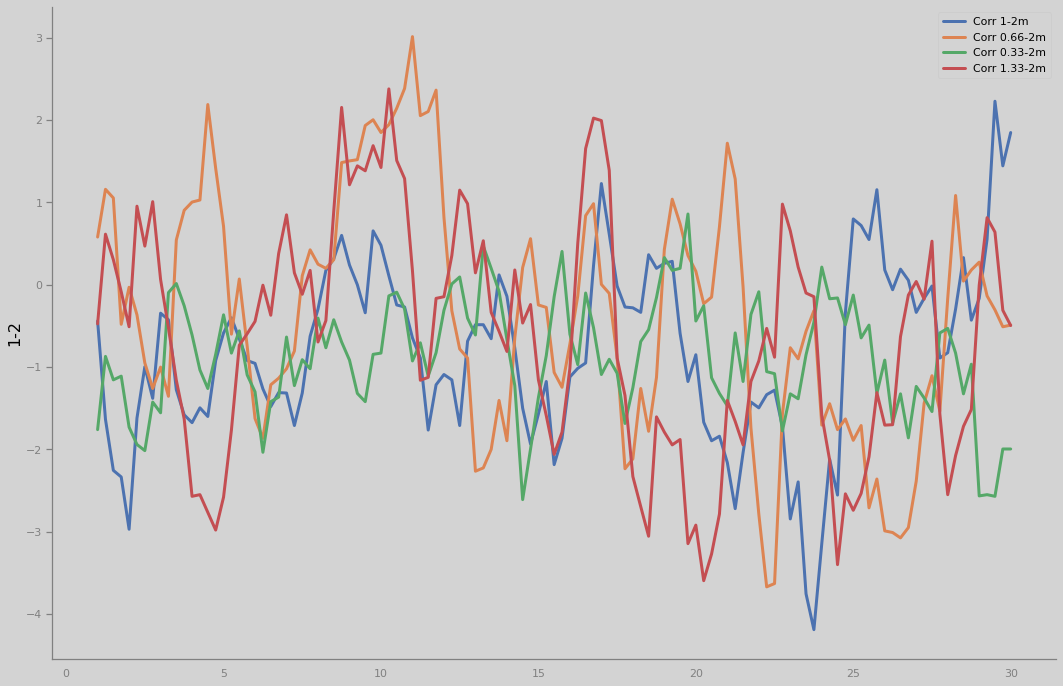

In [238]:
d = {}
for col in cols:
    if '2' in col:
        for i, co in enumerate(lags):
            if i == 0:
                d[col] = co[col].rolling(5).mean()
            else:
                d[col] += co[col].rolling(5).mean()

        d[col] = d[col]/len(corrs)

        sns.lineplot(x = np.linspace(0, 30, len(co)), y = d[col], linewidth = 3, label = f'Corr {col}m')

In [ ]:
from scipy.optimize import curve_fit
x = np.linspace(0,30, len(r[:-1]))
y = r[:-1].values
y = np.log(y)
plt.plot(x,y)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log, validate=True)

x_trans = transformer.fit_transform(x.reshape(-1,1))[1:]
regressor = LinearRegression()
results = regressor.fit(x_trans, y[1:])                # 2
model = results.predict
y_fit = model(x_trans)
plt.plot(x[1:], y_fit, "k--", label="Fit")
# plt.yscale('log')

In [ ]:
r3_1 = 0
r1_2 = 0
    
for i, co in enumerate(corrs):
    co = co.rolling(5).mean()
    if i == 0:
        sns.lineplot(x = np.linspace(0, 30, len(co)), y = co['0.33-1'], color = 'C2', label = 'Pearson Corr between 0.33-1m')
        sns.lineplot(x = np.linspace(0, 30, len(co)), y = co['1-2'], color = 'C3', label = 'Pearson Corr between 1-2m')
    else:
        sns.lineplot(x = np.linspace(0, 30, len(co)), y = co['0.33-1'], color = 'C2')
        sns.lineplot(x = np.linspace(0, 30, len(co)), y = co['1-2'], color = 'C3')
    r3_1 += co['0.33-1']
    r1_2 += co['1-2']
r3_1 = r3_1/len(corrs)
r1_2 = r1_2/len(corrs)
sns.lineplot(x = np.linspace(0, 30, len(co)), y = r3_1, color = 'C2', linewidth = 5)
sns.lineplot(x = np.linspace(0, 30, len(co)), y = r1_2, color = 'C3', linewidth = 5)

In [ ]:
f, ax = plt.subplots(facecolor = 'lightgrey')

r = corrs[0]
for i, s in enumerate(ss):
    if i != 0:
        r = r + s
        sns.lineplot(x = np.linspace(0, 30, len(s)), y = s, ax = ax, color = 'C0', linewidth = 1)
    else:
        sns.lineplot(x = np.linspace(0, 30, len(s)), y = s, ax = ax, color = 'C0', linewidth = 1, label = 'Single Eq Power')
r = r/len(ss)
sns.lineplot(x = np.linspace(0, 30, len(r)), y = r, ax = ax, color = 'black', linewidth = 5, label = 'Mean Eq Power')